## 1. Import libraries

In [0]:
! pip install -q surprise

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [0]:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
product_file_import = drive.CreateFile({'id': '1qZD9r6Luv2pOh4jjfOPHIc4blKeoOnn0'})
product_file_import.GetContentFile('product.csv')
product = pd.read_csv('product.csv')

product.head()

,Unnamed: 0,asin,avg.rating,avg.helpful.ratio,also_bought,also_viewed,brand,categories,description,price,salesRank,title
0,1,7806397051,2.50,NaN,"['B00KR26VFE', 'B00E7LQHZ0', 'B00BMW24TU', 'B0...","['B008GOR6O0', 'B00EOFEKF8', 'B00IIFVJZ4', 'B0...",COKA,"[['Beauty', 'Makeup', 'Face', 'Concealers & Ne...",An extensive range of 15 multiple vibrant long...,5.04,{'Beauty': 10486},WAWO 15 Color Professionl Makeup Eyeshadow Cam...
1,2,9759091062,3.09,NaN,"['B0054GLD1U', 'B003BRZCUC', 'B0054GBXOW', 'B0...","['B0054GBXOW', 'B0054GLD1U', 'B006VDOPPQ', 'B0...",Xtreme Brite,"[['Beauty', 'Hair Care', 'Styling Products', '...",Xtreme Brite Brightening gel is a highly conc...,19.99,{'Beauty': 52254},Xtreme Brite Brightening Gel 1oz.
2,3,9788072216,5.00,NaN,"['B006C5OHSI', 'B006P14842', 'B0072CSVB4', 'B0...","['B0072CSVB4', 'B005YWBOHW', 'B00CGOUL2A', 'B0...",Prada,"[['Beauty', 'Fragrance', ""Women's"", 'Eau de Pa...",Prada Candy By Prada Eau De Parfum Spray 1.7 O...,65.86,{'Beauty': 78916},Prada Candy By Prada Eau De Parfum Spray 1.7 O...
3,4,9790790961,4.60,NaN,"['B007P7OPQQ', 'B0017JT658', 'B0084HM1DA', 'B0...","['B005M2AQRI', 'B000VOHKK8', 'B0017JT658', 'B0...",Versace,"[['Beauty', 'Fragrance', ""Women's"", 'Eau de To...",Versace Bright Crystal Perfume for Women 3 oz ...,52.33,{'Beauty': 764},Versace Bright Crystal Eau de Toilette Spray f...
4,5,9790794231,4.50,NaN,"['B0019M21OQ', 'B000E7YM8K', 'B0006V31FY', 'B0...","['B000E7YM8K', 'B0019M21OQ', 'B0006V31FY', 'B0...",,"[['Beauty', 'Fragrance', ""Women's"", 'Eau de Pa...",STELLA For Women By STELLA MCCARTNEY 1.7 oz ED...,NaN,{'Beauty': 142503},Stella McCartney Stella


In [5]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11346 entries, 0 to 11345
Data columns (total 12 columns):
Unnamed: 0           11346 non-null int64
asin                 11346 non-null object
avg.rating           11346 non-null float64
avg.helpful.ratio    792 non-null float64
also_bought          11346 non-null object
also_viewed          11346 non-null object
brand                11330 non-null object
categories           11346 non-null object
description          10664 non-null object
price                10941 non-null float64
salesRank            11346 non-null object
title                11346 non-null object
dtypes: float64(3), int64(1), object(8)
memory usage: 1.0+ MB


In [6]:
product.describe(include = 'O')

,asin,also_bought,also_viewed,brand,categories,description,salesRank,title
count,11346,11346,11346,11330,11346,10664,11346,11346
unique,11346,11128,11231,2012,251,9790,10157,11314
top,B001T8MN16,,,,"[['Beauty', 'Makeup', 'Nails', 'Nail Polish']]",,,
freq,1,209,103,1804,671,184,187,7


In [0]:
product['also_bought'] = product['also_bought'].fillna('')
product['also_viewed'] = product['also_viewed'].fillna('')
product['brand'] = product['brand'].fillna('')
product['description'] = product['description'].fillna('')
product['title'] = product['title'].fillna('')

In [8]:
product.shape

(11346, 12)

## What's new

In [9]:
product_df = pd.read_csv('product.csv', index_col='title')['description']
print (len(product_df))
print (product_df.head(5))

11346
title
WAWO 15 Color Professionl Makeup Eyeshadow Camouflage Facial Concealer Neutral Palette    An extensive range of 15 multiple vibrant long...
Xtreme Brite Brightening Gel 1oz.                                                         Xtreme Brite  Brightening gel is a highly conc...
Prada Candy By Prada Eau De Parfum Spray 1.7 Oz For Women                                 Prada Candy By Prada Eau De Parfum Spray 1.7 O...
Versace Bright Crystal Eau de Toilette Spray for Women, 3 Ounce                           Versace Bright Crystal Perfume for Women 3 oz ...
Stella McCartney Stella                                                                   STELLA For Women By STELLA MCCARTNEY 1.7 oz ED...
Name: description, dtype: object


__Feature Extraction from description__  
Word Count Vectors
One way to represent an item is to count the instances of every word in the item description. Then descriptions can be compared based on how similar their word count vectors are. Below, I use the CountVectorizer in scikit-learn to generate a vector of word counts for the description on the first item. I then plot the ten most frequently occuring words. As you can see, the most common words are just commonly used words (and, helps). Therefore, these are probably not very helpful in identifying items that are similar.


In [10]:
# product_df[title == 'Xtreme Brite Brightening Gel 1oz.']
product_df= product_df[~pd.isnull(product_df)]
print(product_df.shape)
product_df.head()

(10664,)


title
WAWO 15 Color Professionl Makeup Eyeshadow Camouflage Facial Concealer Neutral Palette    An extensive range of 15 multiple vibrant long...
Xtreme Brite Brightening Gel 1oz.                                                         Xtreme Brite  Brightening gel is a highly conc...
Prada Candy By Prada Eau De Parfum Spray 1.7 Oz For Women                                 Prada Candy By Prada Eau De Parfum Spray 1.7 O...
Versace Bright Crystal Eau de Toilette Spray for Women, 3 Ounce                           Versace Bright Crystal Perfume for Women 3 oz ...
Stella McCartney Stella                                                                   STELLA For Women By STELLA MCCARTNEY 1.7 oz ED...
Name: description, dtype: object

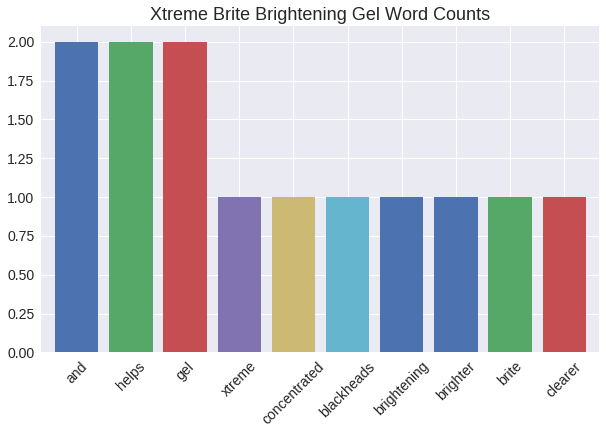

In [11]:
#Extract text for a particular item
title = 'Xtreme Brite Brightening Gel 1oz.'
text = product_df[title]
#Define the count vectorizer that will be used to process the data
count_vectorizer = CountVectorizer()
#Apply this vectorizer to text to get a sparse matrix of counts
count_matrix = count_vectorizer.fit_transform([text])
#Get the names of the features
features = count_vectorizer.get_feature_names()
#Create a series from the sparse matrix
d = pd.Series(count_matrix.toarray().flatten(), 
              index = features).sort_values(ascending=False)

ax = d[:10].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=45,
            title='Xtreme Brite Brightening Gel Word Counts')
ax.title.set_size(18)

### TF-IDF Vectors
Term frequency-inverse document frequency is a statistic that reflects how important a word is to a specific document relative to all of the words in a collection of documents (the corpus). The tf-idf value increases proportionally to the number of times that word appears in the document, but is offset by the frequency of the word in the corpus.

Below, we use a TF-IDF vectorizer to determine the relative importance of the words in the first item description. Unlike the count vectorizer, this one requires the entire corpus as its input, so it takes a little bit longer to run. As you can see, the words with the highest TF-IDF values are now a bit more specific to first item, including words such as "brite", "xtreme", and "gel". 

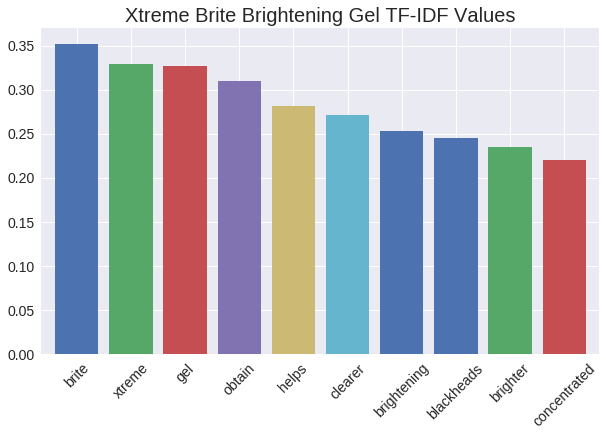

In [12]:
#Define the TFIDF vectorizer that will be used to process the data
tfidf_vectorizer = TfidfVectorizer(analyzer='word',min_df=0,stop_words='english')
#Apply this vectorizer to the full dataset to create normalized vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(product_df)
#Get the names of the features
features = tfidf_vectorizer.get_feature_names()
#get the row that contains relevant vector
row = product_df.index.get_loc(title)
#Create a series from the sparse matrix
d = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(), index = features).sort_values(ascending=False)

ax = d[:10].plot(kind='bar', title='Xtreme Brite Brightening Gel TF-IDF Values',
            figsize=(10,6), width=.8, fontsize=14, rot=45 )
ax.title.set_size(20)

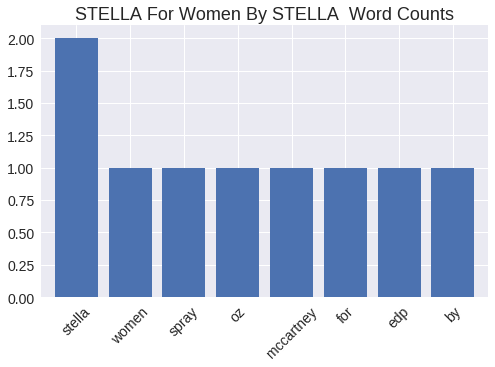

In [13]:
# Another example
title1 = 'Stella McCartney Stella'
text = product_df[title1]
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform([text])
features = count_vectorizer.get_feature_names()
d = pd.Series(count_matrix.toarray().flatten(), 
              index = features).sort_values(ascending=False)

ax = d[:10].plot(kind='bar', figsize=(8,5), width=.8, fontsize=14, rot=45,
            title='STELLA For Women By STELLA  Word Counts',color = 'C0')
ax.title.set_size(18)

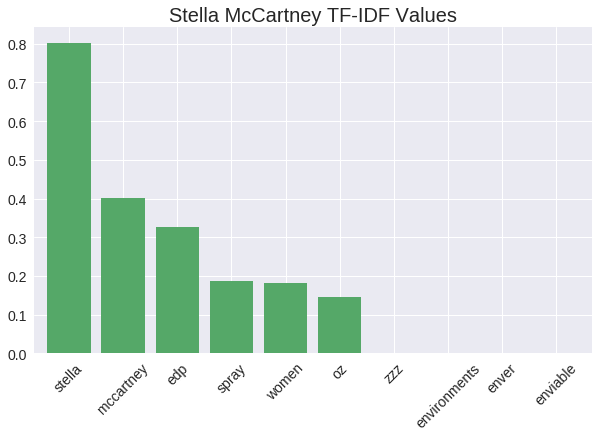

In [14]:
#Define the TFIDF vectorizer that will be used to process the data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
#Apply this vectorizer to the full dataset to create normalized vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(product_df)
#Get the names of the features
features = tfidf_vectorizer.get_feature_names()
#get the row that contains relevant vector
row = product_df.index.get_loc(title1)
#Create a series from the sparse matrix
d = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(), index = features).sort_values(ascending=False)

ax = d[:10].plot(kind='bar', title='Stella McCartney TF-IDF Values',
            figsize=(10,6), width=.8, fontsize=14, rot=45, color = 'C1' )
ax.title.set_size(20)

In [15]:
d

stella             0.802225
mccartney          0.401112
edp                0.326104
spray              0.187490
women              0.181018
oz                 0.145876
zzz                0.000000
environments       0.000000
enver              0.000000
enviable           0.000000
enviro             0.000000
enviromental       0.000000
environme          0.000000
environment        0.000000
environmental      0.000000
environmentally    0.000000
enzo               0.000000
envision           0.000000
envy               0.000000
envyreduce         0.000000
enveloping         0.000000
enzymatic          0.000000
enzyme             0.000000
enzymes            0.000000
enzymetherapy      0.000000
eo                 0.000000
envelops           0.000000
envelope           0.000000
envelopes          0.000000
enveloped          0.000000
                     ...   
peter              0.000000
petit              0.000000
petite             0.000000
petitgrain         0.000000
petro              0

## Using K-Nearest Neighbors to Identify Similar items

Now, we have our TF-IDF matrix, which is a sparse matrix of TF-IDF values for every word in every one of the item description. The ```NearestNeighbors``` function can be fit on this sparse matrix and will determine the distance between articles based on their TF-IDF values. I specify that I want to return the ```10 nearest neighbors``` for each item. By default, this function uses Minkowski distance, other common distance metrics (Euclidean, Cosine, Manhattan) can be specified as well.

Below I write a function that takes a name as its input and returns a ```Series``` of the 10 nearest neighbors along with their distances. 

In [0]:
nbrs = NearestNeighbors(n_neighbors=10).fit(tfidf_matrix)

def get_closest_neighs(title):
    row = product_df.index.get_loc(title)
    distances, indices = nbrs.kneighbors(tfidf_matrix.getrow(row))
    names_similar = pd.Series(indices.flatten()).map(product_df.reset_index()['title'])
    result = pd.DataFrame({'distance':distances.flatten(), 'title':names_similar})
    return result

In [17]:
get_closest_neighs('Stella McCartney Stella')

,distance,title
0,0.0,Stella McCartney Stella
1,1.0,Rockland Luggage Rockland 2 Piece Cosmetic Set
2,1.0,Travel Smart by Conair 1875-Watt Folding Trave...
3,1.0,OPI Mini Disney Couture De Minnie 2013
4,1.0,China Glaze Magnetix II Magnet
5,1.0,Rockland Luggage 19 Inch Tote Bag
6,1.0,Bosley Healthy Hair Vitality Supplement for Wo...
7,1.0,Herbal Essences Long Term Relationship Leave-I...
8,1.0,Conair Collapsible Hard Hat Hair Dryer
9,1.0,MapofBeauty Full Wavy Women's Wig Long Curly L...


In [18]:
get_closest_neighs('Xtreme Brite Brightening Gel 1oz.')

,distance,title
0,0.000000,Xtreme Brite Brightening Gel 1oz.
1,0.604173,Xtreme Brite Brightening Gel 1oz
2,0.674926,Xtreme Brite Brightening Gel 1oz x 3pcs
3,0.983481,Xtreme Brite Brightening Gel 1oz (2-Pack)
4,1.000000,Spenco Yumi - Women's Sandal - Caramel/Coffee
5,1.000000,MapofBeauty Full Wavy Women's Wig Long Curly L...
6,1.000000,Wee Ones Baby Girls' Knot Genie Teeny Genie-Pe...
7,1.000000,Scarecrow SMALL Realistic Deluxe Custom Fangs Box
8,1.000000,Spenco Polysorb Total Support
9,1.000000,Soft 'N Style Hot Roller Clamp (6 Per Bag) (Pa...


## Using Cosine Similarity Score to Identify Similar items

Let us first try to build a recommender using descriptions only

In [19]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(product['description'])
tfidf_matrix

<11346x262450 sparse matrix of type '<class 'numpy.float64'>'
	with 874430 stored elements in Compressed Sparse Row format>

In [20]:
# how many keys words do we count overall
max(tfidf_matrix[[0]])

<1x262450 sparse matrix of type '<class 'numpy.float64'>'
	with 164 stored elements in Compressed Sparse Row format>

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. 

In [21]:
cosine_similarity(X = tfidf_matrix, Y=None, dense_output=True)

array([[1.        , 0.0044185 , 0.        , ..., 0.        , 0.01131413,
        0.01138293],
       [0.0044185 , 1.        , 0.        , ..., 0.        , 0.00751717,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.00551829],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01131413, 0.00751717, 0.        , ..., 0.        , 1.        ,
        0.00793195],
       [0.01138293, 0.        , 0.00551829, ..., 0.        , 0.00793195,
        1.        ]])

We can also use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [0]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [23]:
cosine_sim[1]

array([0.0044185 , 1.        , 0.        , ..., 0.        , 0.00751717,
       0.        ])

We now have a pairwise cosine similarity matrix for all the items in our dataset. 

In [0]:
product = product.reset_index()
titles = product['title']
indices = pd.Series(product.index, index=product['title'])

In [25]:
# get title name
indices.head()

title
WAWO 15 Color Professionl Makeup Eyeshadow Camouflage Facial Concealer Neutral Palette    0
Xtreme Brite Brightening Gel 1oz.                                                         1
Prada Candy By Prada Eau De Parfum Spray 1.7 Oz For Women                                 2
Versace Bright Crystal Eau de Toilette Spray for Women, 3 Ounce                           3
Stella McCartney Stella                                                                   4
dtype: int64

Create a function that takes a single row of the tf-idf matrix (corresponding to a particular document), and return the n highest scoring words (or more generally tokens or features):

In [0]:
def get_highest_cosine_sim(title):
    # get index of a particular item
    idx = indices[title]
    # list score of each title
    sim_scores = list(enumerate(cosine_sim[idx]))
    # sort scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # get 30 highest scores exclude itself
    sim_scores = sim_scores[1:31]
    # print(sim_scores)
    # get item index
    item_indices = [i[0] for i in sim_scores]
    item_distance = [j[1] for j in sim_scores]
    result = pd.DataFrame({'distance':item_distance, 'title': titles.iloc[item_indices]})
    return result

In [27]:
get_highest_cosine_sim('Stella McCartney Stella').head(10)

,distance,title
7522,0.284619,Jessica Simpson I Fancy You Women Eau De Parfu...
341,0.265153,Pheromone By Marilyn Miglin For Women. Eau De ...
1526,0.163313,Sarah Jessica Parker Lovely Eau de Parfum Spra...
2244,0.132577,Sex In The City Kiss by Instyle Parfums Eau De...
6806,0.123196,"Jimmy Choo Women Eau De Parfum Spray, 3.3 Ounce"
6390,0.098751,Karen Low Pure Pink Eau De Parfum Spray for Wo...
3810,0.095380,Sensual By Johan B Perfume for Women 2.8 Oz / ...
5685,0.090665,"Sex In The City Love for Women, Eau De Parfum ..."
951,0.079455,Paris Hilton by Paris Hilton for Women - 1.7 O...
903,0.074957,PALOMA PICASSO For Women By PALOMA PICASSO Eau...


## Create User Profile

In [0]:
bb_file_import = drive.CreateFile({'id': '153U3ooeV1FNCiGQ0bzQREYDC6gkS6O5D'})
bb_file_import.GetContentFile('Beauty_5.json')

In [29]:
import pandas as pd
import csv
import json
import re

# data in json file is not in valid json format
# process each line before paser it
def process_line(l):
    # replace "" with "
    l_n = l.replace('""', '"')
    # extract valid json part and the extra field
    m = re.match(r'^"(.*)"\t"(\d{4})"}"$', l_n)
    if not m:
        assert(False)
    json_str = m[1]
    year = m[2]
    # parse json part
    json_v = json.loads(json_str)
    return (json_v, year)

# read json file
with open('Beauty_5.json') as f:
    lines = [line.rstrip('\n') for line in f]

# each line is a json item
json_rows = []
# there is an extra field on each line
year_rows = []
# parse json line by line
for l in lines:
    json_v, year = process_line(l)
    json_rows.append(json_v)
    year_rows.append(year)

# get column name for csv file
col_name = [k for k, v in json_rows[0].items()]

# write csv file
with open("Beauty_5.csv", "w") as fw:
    cvs_writer = csv.writer(fw)
    cvs_writer.writerow([*col_name, 'year'])
    for jr, year in zip(json_rows, year_rows):
        row = [jr[k] if k in jr else '' for k in col_name]
        cvs_writer.writerow([*row, year])

# load to pandas and verify
beauty_data = pd.read_csv('Beauty_5.csv').rename(columns={'overall':'rating'})
beauty_data.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,rating,summary,unixReviewTime,reviewTime,year
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014",2014
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014",2014
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013",2013
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013",2013
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013",2013
5,A3BTN14HIZET6Z,7806397051,"S. M. Randall ""WildHorseWoman""","[1, 2]","I was very happy to get this palette, now I wi...",5.0,Very nice palette!,1365984000,"04 15, 2013",2013
6,A1Z59RFKN0M5QL,7806397051,"tasha ""luvely12b""","[1, 3]",PLEASE DONT DO IT! this just rachett the palet...,1.0,smh!!!,1376611200,"08 16, 2013",2013
7,AWUO9P6PL1SY8,7806397051,TreMagnifique,"[0, 1]","Chalky,Not Pigmented,Wears off easily,Not a Co...",2.0,"Chalky, Not Pigmented, Wears off easily, Not a...",1378252800,"09 4, 2013",2013
8,A3LMILRM9OC3SA,9759091062,NaN,"[0, 0]",Did nothing for me. Stings when I put it on. I...,2.0,"no Lightening, no Brightening,......NOTHING",1405209600,"07 13, 2014",2014
9,A30IP88QK3YUIO,9759091062,Amina Bint Ibraheem,"[0, 0]",I bought this product to get rid of the dark s...,3.0,Its alright,1388102400,"12 27, 2013",2013


In [30]:
beauty_data.describe(include='O')

,reviewerID,asin,reviewerName,helpful,reviewText,summary,reviewTime
count,143560,143560,142418,143560,143549,143559,143560
unique,20607,11891,18283,611,143502,100064,569
top,ALNFHVS3SC4FV,B004OHQR1Q,Amazon Customer,"[0, 0]",Love it,Love it,"04 5, 2013"
freq,161,376,1697,91986,4,757,634


In [31]:
beauty_data.describe()

,rating,unixReviewTime,year
count,143560.000000,1.435600e+05,143560.000000
mean,4.202243,1.382359e+09,2013.406165
std,1.156612,1.454541e+07,0.491118
min,1.000000,1.356998e+09,2013.000000
25%,4.000000,1.368749e+09,2013.000000
50%,5.000000,1.383610e+09,2013.000000
75%,5.000000,1.395274e+09,2014.000000
max,5.000000,1.406074e+09,2014.000000


In [0]:
# We only need data from 2013 to 2014
beauty = beauty_data.loc[(beauty_data['year']==2013) | (beauty_data['year']==2014),['reviewerID', 'asin', 'rating',  'year']]

In [33]:
beauty.head()

,reviewerID,asin,rating,year
0,A1YJEY40YUW4SE,7806397051,1.0,2014
1,A60XNB876KYML,7806397051,3.0,2014
2,A3G6XNM240RMWA,7806397051,4.0,2013
3,A1PQFP6SAJ6D80,7806397051,2.0,2013
4,A38FVHZTNQ271F,7806397051,3.0,2013


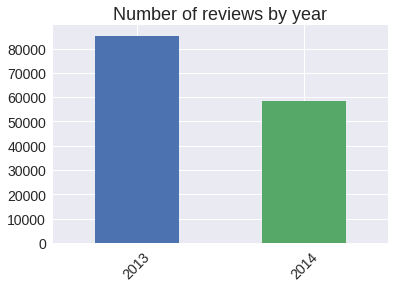

In [34]:
ax = beauty['year'].value_counts().plot(kind='bar', title='Number of reviews by year', fontsize=14, rot=45)
ax.title.set_size(18)

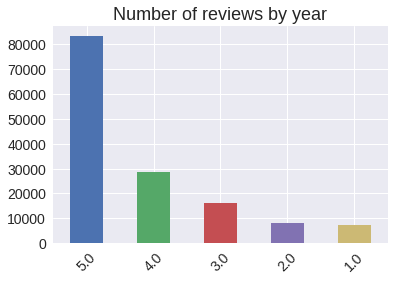

In [35]:
ax = beauty['rating'].value_counts().plot(kind='bar', title='Number of reviews by year', fontsize=14, rot=45)
ax.title.set_size(18)

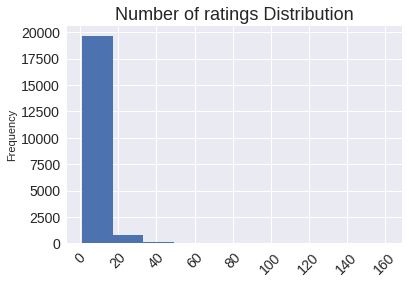

In [36]:
# calculate average score each review id gives and how many items each reviwer rates
reviewer_avg_rt = beauty.groupby('reviewerID', as_index = False)['rating'].agg({'reviewer_avg_ratings':'mean', 'num_ratings':'count'})
ax = reviewer_avg_rt['num_ratings'].plot(kind='hist', title='Number of ratings Distribution', fontsize=14, rot=45)
ax.title.set_size(18)

In [37]:
reviewer_avg_rt['num_ratings'].value_counts().sort_values(ascending=False)

5      5021
6      2964
4      1883
7      1831
3      1350
8      1225
2      1201
1      1024
9       892
10      573
11      476
12      353
13      282
14      234
15      178
16      135
17      117
19       83
18       77
21       75
20       74
22       60
23       53
24       52
29       28
26       25
25       24
27       23
30       22
32       21
       ... 
65        2
81        2
70        2
62        2
66        2
67        2
74        2
76        2
106       1
100       1
85        1
63        1
87        1
103       1
135       1
56        1
73        1
89        1
84        1
75        1
139       1
61        1
77        1
52        1
98        1
143       1
97        1
161       1
82        1
71        1
Name: num_ratings, Length: 92, dtype: int64

In [38]:
# We would like to delete users that rated less than or equal to 3 times since it is hard to analyze their past behavior
reviewer_avg_rt['num_ratings'].value_counts()
print('There are {0} reviewers rated less than or equal to 3 times'.format(reviewer_avg_rt.loc[reviewer_avg_rt['num_ratings']<4].shape[0]))
reviewer_avg_rt.shape

There are 3575 reviewers rated less than or equal to 3 times


(20607, 3)

In [39]:
reviewer_avg_rt_trimed = reviewer_avg_rt.loc[reviewer_avg_rt['num_ratings']>3]
reviewer_avg_rt_trimed.head()

,reviewerID,reviewer_avg_ratings,num_ratings
0,A00414041RD0BXM6WK0GX,3.166667,6
1,A00473363TJ8YSZ3YAGG9,3.333333,6
2,A00700212KB3K0MVESPIY,5.000000,9
3,A0078719IR14X3NNUG0F,4.875000,8
4,A01198201H0E3GHV2Z17I,3.833333,6


In [40]:
beauty.head()

,reviewerID,asin,rating,year
0,A1YJEY40YUW4SE,7806397051,1.0,2014
1,A60XNB876KYML,7806397051,3.0,2014
2,A3G6XNM240RMWA,7806397051,4.0,2013
3,A1PQFP6SAJ6D80,7806397051,2.0,2013
4,A38FVHZTNQ271F,7806397051,3.0,2013


In [41]:
# join table
# define standard ratings as overall_rating - avg_rating
beauty_merged = beauty.merge(reviewer_avg_rt_trimed, how = 'inner')
beauty_merged['std_ratings'] = beauty_merged['rating'] - beauty_merged['reviewer_avg_ratings']
beauty_merged.tail()

,reviewerID,asin,rating,year,reviewer_avg_ratings,num_ratings,std_ratings
136079,A2CG5Y82ZZNY6W,B00JK3ZHIS,4.0,2014,4.2,5,-0.2
136080,A2CG5Y82ZZNY6W,B00KAL5JAU,4.0,2014,4.2,5,-0.2
136081,A2CG5Y82ZZNY6W,B00KHGIK54,4.0,2014,4.2,5,-0.2
136082,A2CG5Y82ZZNY6W,B00KHH2VOY,4.0,2014,4.2,5,-0.2
136083,A2CG5Y82ZZNY6W,B00KQBR9FM,5.0,2014,4.2,5,0.8


In [42]:
# merge 2 datasets to create user profile
combine = product.merge(beauty_merged, on='asin', how = 'inner')
product.shape, beauty_merged.shape, combine.shape

((11346, 13), (136084, 7), (133310, 19))

In [43]:
user = combine[['asin','reviewerID','rating','year','std_ratings']].rename(columns = {'asin':'item_id', 'reviewerID':'user_id'})
user.head()

,item_id,user_id,rating,year,std_ratings
0,7806397051,A60XNB876KYML,3.0,2014,-1.428571
1,7806397051,A3G6XNM240RMWA,4.0,2013,-0.555556
2,7806397051,A1PQFP6SAJ6D80,2.0,2013,-0.833333
3,7806397051,A38FVHZTNQ271F,3.0,2013,0.000000
4,7806397051,A3BTN14HIZET6Z,5.0,2013,0.312500


## 3. Train-test split

In [0]:
# np.random.seed(1234)
# chosen_idx = np.random.choice(len(combine), replace=False, size=round(len(combine)*0.8))
# mask = np.array([(i in chosen_idx) for i in range(len(combine))])

# train_df = combine[mask]
# test_df = combine[~mask]
# len(train_df),len(test_df)

In [44]:
user.head()

,item_id,user_id,rating,year,std_ratings
0,7806397051,A60XNB876KYML,3.0,2014,-1.428571
1,7806397051,A3G6XNM240RMWA,4.0,2013,-0.555556
2,7806397051,A1PQFP6SAJ6D80,2.0,2013,-0.833333
3,7806397051,A38FVHZTNQ271F,3.0,2013,0.000000
4,7806397051,A3BTN14HIZET6Z,5.0,2013,0.312500


In [45]:
user.shape

(133310, 5)

In [46]:
# unique number of usets
len(set(user['user_id']))

17032

In [47]:
# total number of users
len(user['user_id'])

133310

In [0]:
reviewerID_length = len(list(set(user['user_id'])))
unique_reviewerID = list(set(user['user_id']))

In [49]:
unique_mat = np.zeros((reviewerID_length, 4))
unique_mat.shape

(17032, 4)

In [50]:
reviewerID_length

17032

In [51]:
product['asin'].head()

0    7806397051
1    9759091062
2    9788072216
3    9790790961
4    9790794231
Name: asin, dtype: object

In [52]:
user.shape[0]

133310

In [53]:
print(user.groupby('user_id', as_index = False)['item_id'])

In [54]:
user.groupby(['user_id','item_id'])

In [0]:
user = user.sort_values(by=['user_id'])

In [56]:
user.head(30)

,item_id,user_id,rating,year,std_ratings
91352,B00870XLDS,A00414041RD0BXM6WK0GX,2.0,2014,-1.166667
94045,B008MIRO88,A00414041RD0BXM6WK0GX,1.0,2014,-2.166667
87194,B007IY97U0,A00414041RD0BXM6WK0GX,3.0,2014,-0.166667
127211,B00HFP4JZU,A00414041RD0BXM6WK0GX,5.0,2014,1.833333
113917,B00BQYYMN0,A00414041RD0BXM6WK0GX,3.0,2014,-0.166667
123792,B00GRTQBTM,A00414041RD0BXM6WK0GX,5.0,2014,1.833333
111564,B00B18C2RE,A00473363TJ8YSZ3YAGG9,3.0,2014,-0.333333
37456,B0020HEBX8,A00473363TJ8YSZ3YAGG9,4.0,2013,0.666667
33778,B001L2BEWE,A00473363TJ8YSZ3YAGG9,4.0,2013,0.666667
657,B000052YQU,A00473363TJ8YSZ3YAGG9,2.0,2014,-1.333333


In [57]:
user['user_id'].head()

91352     A00414041RD0BXM6WK0GX
94045     A00414041RD0BXM6WK0GX
87194     A00414041RD0BXM6WK0GX
127211    A00414041RD0BXM6WK0GX
113917    A00414041RD0BXM6WK0GX
Name: user_id, dtype: object

In [58]:
user.shape[0]

133310

In [0]:
df_asin = [] # 存asin 的list
df_rating = [] # 存 
for i in range(reviewerID_length):
  list_in_list1 = []
  list_in_list2 = []
  df_asin.append(list_in_list1)
  df_rating.append(list_in_list2)


In [0]:
#df_asin
#df_rating[1]

In [0]:
pos_in_list = 0
#cur_pos = 0
for i in range(user.shape[0]):
  
  if i == 0:
    #print('pos_in_list: ',pos_in_list)
    #print(user['asin'].iloc[0])
    #print(user['overall'].iloc[0])
    #print('##############')
    df_asin[pos_in_list].append(user['asin'].iloc[0]) # append 里面 的 内容 不变
    df_rating[pos_in_list].append(user['overall'].iloc[0])
    #print("list=",df_asin[pos_in_list])
    #print('i: ',i)
  if i > 0:
    if user['reviewerID'].iloc[i] == user['reviewerID'].iloc[i-1]:
      #print('pos_in_list: ',pos_in_list)
      #print(user['asin'].iloc[i])
      #print(user['overall'].iloc[i])
      #print('##############')
      df_asin[pos_in_list].append(user['asin'].iloc[i]) # append 里面 的 内容 不变
      df_rating[pos_in_list].append(user['overall'].iloc[i])
      #print('i: ',i)
      #print("list=",df_asin[pos_in_list])
    if user['reviewerID'].iloc[i] != user['reviewerID'].iloc[i-1]:
      #print('!=  ',user['reviewerID'].iloc[i],user['reviewerID'].iloc[i-1])
      pos_in_list = pos_in_list + 1
      #print('pos_in_list: ',pos_in_list)
      #print(user['asin'].iloc[i])
      #print(user['overall'].iloc[i])
      #print('##############')
      df_asin[pos_in_list].append(user['asin'].iloc[i]) # append 里面 的 内容 不变
      df_rating[pos_in_list].append(user['overall'].iloc[i])
      #print('i: ',i)
      #print("list=",df_asin[pos_in_list])
   

KeyError: ignored

In [0]:
#list_try = [[],[],[],[]]#[[3,5,6,7,8],[2,3,4],[7,5,4,2,8],[1,2,3]]
#list_try[0].append(1)
#list_try[0].append(2)
#list_try[1].append(5)
#list_try

In [0]:
df_reviewerID = []
for i in range(user.shape[0]):
  if i == 0:
    df_reviewerID.append(user['reviewerID'].iloc[0])
  else:
    if user['reviewerID'].iloc[i] != user['reviewerID'].iloc[i-1]:
      df_reviewerID.append(user['reviewerID'].iloc[i])

KeyError: ignored

In [0]:
df_ratingAvg = []
for i in range(len(df_rating)):
  df_ratingAvg.append(np.mean(df_rating[i]))

In [0]:
user['asin'].iloc[3]

KeyError: ignored

In [0]:
user.shape[0]

133310

In [0]:
user['asin'].iloc[10]

KeyError: ignored

## 4. Evaluation